# 1. Установка


In [1]:
import tensorflow as tf
import os

In [2]:
import cv2
import imghdr

In [3]:
import numpy as np
from matplotlib import pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data_dir = '/content/drive/MyDrive/youtubevid/imageclassMS/Multiple Sclerosis'

In [6]:
os.listdir('/content/drive/MyDrive/youtubevid/imageclassMS/Multiple Sclerosis')

['NotMS', 'MS']

In [7]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [8]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [9]:
img_height = 256
img_width = 512

In [10]:
data = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(img_height, img_width))

Found 3427 files belonging to 2 classes.


In [11]:
data_iterator = data.as_numpy_iterator()

In [12]:
batch = data_iterator.next()

In [13]:
batch[1]
# class 0 = MS
# class 1 = NotMS

array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1], dtype=int32)

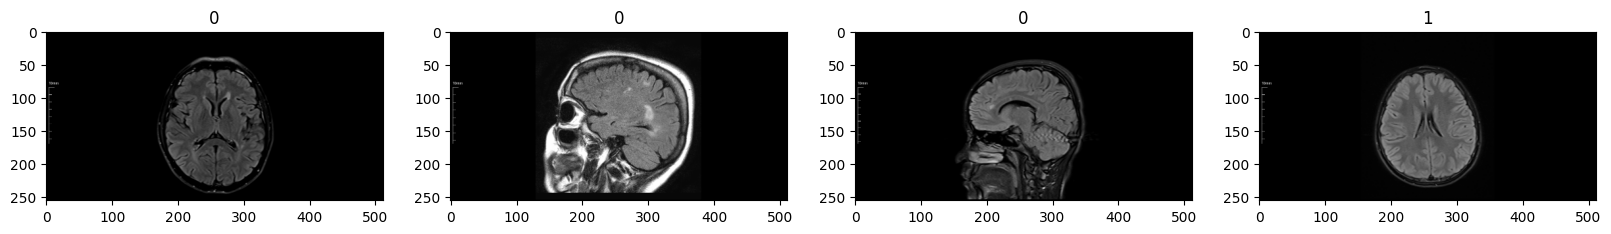

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 2. Обрабатываем данные

In [15]:
data = data.map(lambda x,y: (x/255, y))

In [16]:
data.as_numpy_iterator().next()

(array([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],
 
 
        [

# 3. Делим на тест\тренировочные данные

In [17]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [18]:
train_size

75

In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 4. Строим модель




In [20]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [22]:
model = Sequential()

In [23]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,512,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [24]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 510, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 255, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 253, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 126, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 124, 16)       4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 62, 16)        0

# 5. Тренируем


In [26]:
logdir='logs'

In [27]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [28]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
75/75 [==============================] - 75s 884ms/step - loss: 0.5020 - accuracy: 0.7513 - val_loss: 0.3852 - val_accuracy: 0.8274
Epoch 2/20
75/75 [==============================] - 58s 754ms/step - loss: 0.3214 - accuracy: 0.8629 - val_loss: 0.3531 - val_accuracy: 0.8467
Epoch 3/20
75/75 [==============================] - 67s 878ms/step - loss: 0.2792 - accuracy: 0.8825 - val_loss: 0.4137 - val_accuracy: 0.8304
Epoch 4/20
75/75 [==============================] - 71s 923ms/step - loss: 0.1952 - accuracy: 0.9246 - val_loss: 0.2491 - val_accuracy: 0.8958
Epoch 5/20
75/75 [==============================] - 69s 904ms/step - loss: 0.1167 - accuracy: 0.9583 - val_loss: 0.2053 - val_accuracy: 0.9345
Epoch 6/20
75/75 [==============================] - 67s 871ms/step - loss: 0.0943 - accuracy: 0.9654 - val_loss: 0.2275 - val_accuracy: 0.9122
Epoch 7/20
75/75 [==============================] - 69s 900ms/step - loss: 0.0641 - accuracy: 0.9771 - val_loss: 0.1898 - val_accuracy: 0.9390

# 6. Чекаем производительность модели


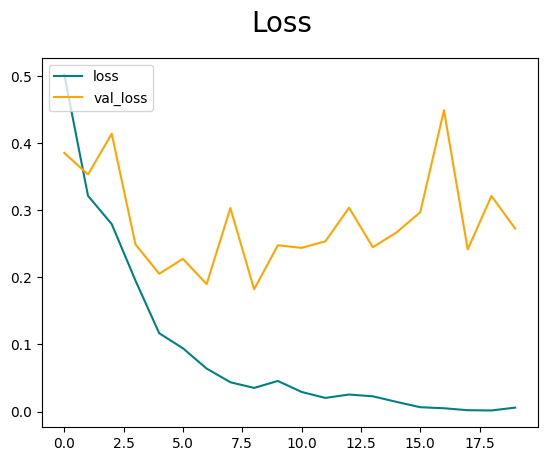

In [29]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

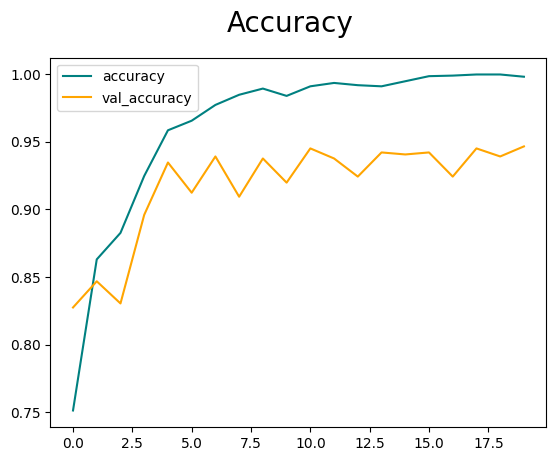

In [30]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 7. Оцениваем

In [31]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [32]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [33]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 61ms/step


In [34]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.9408602, shape=(), dtype=float32) tf.Tensor(0.93582886, shape=(), dtype=float32) tf.Tensor(0.928125, shape=(), dtype=float32)


# 8. Тестируем

In [78]:
import cv2

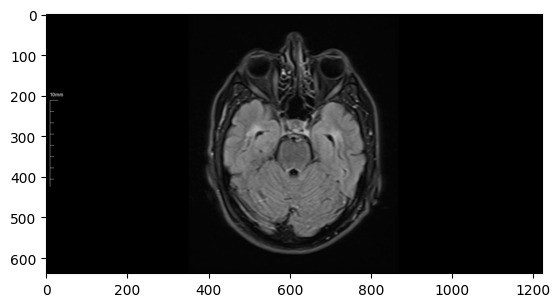

In [79]:
img = cv2.imread('/content/drive/MyDrive/youtubevid/imageclassMS/ms5.png')
plt.imshow(img)
plt.show()

In [80]:
resize = tf.image.resize(img, (img_height,img_width))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [81]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 19ms/step


In [82]:
yhat

array([[2.2662238e-08]], dtype=float32)

In [83]:
if yhat > 0.5:
    print(f'Predicted class is NotMS')
else:
    print(f'Predicted class is MS')

Predicted class is MS
